In [558]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List
from tqdm import tqdm
import os
import json
import random
from numpy import longdouble
from sklearn.utils import shuffle
# import pathos.multiprocessing as mpathos
import sentencepiece as spm
# import numpy_ml.neural_nets.losses as CE

sp = spm.SentencePieceProcessor()
sp.load('spm_model_5k.model')

text = "This is a sample sentence to tokenize."
tokens = sp.encode_as_pieces(text)
print(tokens)
print(sp.encode_as_ids(text))
print(sp.decode(sp.encode_as_ids(text)))

['▁This', '▁is', '▁a', '▁sa', 'mp', 'le', '▁sent', 'ence', '▁to', '▁to', 'ken', 'ize', '.']
[115, 22, 15, 1351, 1197, 245, 412, 927, 6, 6, 3159, 2044, 3]
This is a sample sentence to tokenize.


In [559]:
def find_max_sequence_length():
    maxlen = 0
    prefix = './PhishingEmails/'  # Adjust this to your file path
    
    for file in tqdm(os.listdir(prefix)):
        with open(prefix + file) as jsonFile:
            jsonStr = jsonFile.read()
            email_dict = json.loads(jsonStr)
            setupData = sp.encode_as_ids(
                email_dict['email_subject'].strip() + ". " + email_dict['email_body'].strip()
            )

            if(len(setupData) < 801):
                maxlen = max(maxlen, len(setupData))

    return maxlen

In [560]:
def load_emails(batch_size, windows_size):

    max_sequence_length = find_max_sequence_length()
    dataset = []
    batch_counter = 0
    batch = []
    ctr = 0
    
    prefix = './PhishingEmails/' #change this to the prefile thing such as './celebA'

    for file in tqdm(os.listdir(prefix)):
        
        with open(prefix + file) as jsonFile:
            jsonStr = jsonFile.read() #json file as a string
            email_dict = json.loads(jsonStr) #converts to dictionary
        
        setupData = sp.encode_as_ids(email_dict['email_subject'].strip() + ". " + email_dict['email_body'].strip())
        pad_length = max_sequence_length - len(setupData)

        if(len(setupData) <= max_sequence_length):
     
            ctr+=1

            for i in range(windows_size, len(setupData) - windows_size - 1):

                if batch_counter < batch_size:
                    batch.append(np.array(setupData[i:i+windows_size],dtype=longdouble))
                    batch_counter += 1
                else:
                    dataset.append(batch)
                    batch = []
                    batch_counter = 0
    dataset = np.array(dataset)
    np.random.shuffle(dataset)
    
    return dataset

In [561]:
#Initialize helpful functions for math
def sigmoid(x: np.ndarray):
    return 1/(1+np.exp(-1*x))

def sigmoid_derivative(x: np.ndarray):
    return sigmoid(x)*(1-sigmoid(x))

def tanh(x: np.ndarray):
    return np.tanh(x)
    
def tanh_derivative(x:np.ndarray):
    return 1-np.square(tanh(x))

def softmax(x: np.ndarray):
    return np.exp(x)/np.sum(np.exp(x))

# def cross_entropy(yhat, y, epsilon=1e-10):
#     for i in range(len(yhat)):
 
#         loss = loss + (-1 * y[i]*np.log(yhat[i]))
def cross_entropy(yhat, y, epsilon=1e-12):
    predictions = np.clip(yhat, epsilon, 1. - epsilon)
    N = predictions.shape[0]
    ce = -np.sum(y*np.log(predictions+1e-9))/N
    return ce

def initWeights(input_size, output_size):
    return np.random.uniform(-1, 1, (input_size, output_size)).astype(longdouble) * np.sqrt(1 / (input_size + output_size))



In [562]:
#initializes the weights of the network
def initialize_cell(input_size, hidden_size):
    
    cell = {}

    cell["W_i"] = np.vstack((initWeights(hidden_size, hidden_size), initWeights(input_size, hidden_size))) #input gate weights
    cell["W_f"] = np.vstack((initWeights(hidden_size, hidden_size), initWeights(input_size, hidden_size))) #forget gate weights
    cell["W_c"] = np.vstack((initWeights(hidden_size, hidden_size), initWeights(input_size, hidden_size))) #candidate gate weights
    cell["W_o"] = np.vstack((initWeights(hidden_size, hidden_size), initWeights(input_size, hidden_size))) #output gate weights
    cell["W_y"] = initWeights(hidden_size, 5000)#final gate weights

    #not sure if the biases need to be 3d...
    cell["b_i"] = np.zeros(hidden_size,dtype=longdouble) #input gate biases
    cell["b_f"] = np.zeros(hidden_size,dtype=longdouble) #forget gate biases
    cell["b_c"] = np.zeros(hidden_size,dtype=longdouble) #candidate gate biases
    cell["b_o"] = np.zeros(hidden_size,dtype=longdouble) #output gate biases
    cell["b_y"] = np.zeros(5000) #final gate biases

    return cell

In [563]:
#forward pass of all gates
def forward_pass(cell, prevA, prevC, X):

    input = np.hstack((prevA, X))
   
    forward = {}

    forward["F"] = sigmoid(input.dot(cell["W_f"]) + cell["b_f"])

    forward["_c"] = input.dot(cell["W_c"]) + cell["b_c"]
    
    forward["C"] = tanh(forward["_c"])

    forward["I"] = sigmoid(input.dot(cell["W_i"]) + cell["b_i"])

    forward["O"] = sigmoid(input.dot(cell["W_o"]) + cell["b_o"])


    forward["prevA"] = prevA
    forward["prevC"] = prevC
    forward["C_t"] = (forward["prevC"] * forward["F"]) + (forward["I"] * forward["C"])
    forward["A_t"] = forward["O"] * tanh(forward["C_t"])

    forward["Z_t"] = forward["A_t"].dot(cell["W_y"]) + cell["b_y"]

    forward["Yhat"] = softmax(forward["Z_t"][0])

    # print(forward["Z_t"].size)
    for i in range(1,len(forward["Z_t"])):
        sm = softmax(forward["Z_t"][i])
        forward["Yhat"] = np.vstack((forward["Yhat"], sm))
    # print(forward["Yhat"][0][0:100])

    # print()
    # forward["Yhat"] = softmax(forward["Z_t"])
    # print(forward["Yhat"].size)

    return forward

In [564]:
def gradient(forward, cell, X, Y, lprimea, lprimec, hidden_size):
    Y = np.array(Y)
    
    grads = {}

    input = np.hstack((forward["prevA"], X))
    

    dldA_t = (forward["Yhat"]- Y).dot(np.transpose(cell["W_y"])) + lprimea
    
    dldC_t = lprimec + (forward["O"] * tanh_derivative(forward["C_t"])) * dldA_t 

    TdLdw_f = (dldC_t * forward["prevC"] * forward["F"]*(1-forward["F"])) 

    TdLdw_c = (dldC_t * forward["I"]*tanh_derivative(forward["_c"]))
    TdLdw_o = (dldA_t * tanh(forward["C_t"]) * forward["O"] * (1-forward["O"]))
    TdLdw_i = (dldC_t * forward["C"] * forward["I"] * (1-forward["I"]))
    TdLdw_y = (forward["Yhat"]-Y)

    woa = cell["W_o"][:hidden_size, :]
    wca = cell["W_c"][:hidden_size, :]
    wia = cell["W_i"][:hidden_size, :]
    wfa = cell["W_f"][:hidden_size, :]

    grads["dLda_prev"] = TdLdw_o.dot(woa.T) + TdLdw_c.dot(wca.T) + TdLdw_i.dot(wia.T) + TdLdw_f.dot(wfa.T)
    grads["dLdc_prev"] = (lprimec + (forward["O"] * tanh_derivative(forward["C_t"]) * dldA_t)) * forward["F"]

    grads["dLdw_f"] = np.atleast_2d(input).T.dot(np.atleast_2d(TdLdw_f))
    grads["dLdw_c"] = np.atleast_2d(input).T.dot(np.atleast_2d(TdLdw_c))
    grads["dLdw_o"] = np.atleast_2d(input).T.dot(np.atleast_2d(TdLdw_o))
    grads["dLdw_i"] = np.atleast_2d(input).T.dot(np.atleast_2d(TdLdw_i))
    grads["dLdw_y"] = np.atleast_2d(np.atleast_2d(forward["A_t"])).T.dot(np.atleast_2d(TdLdw_y))

    grads["dLdb_f"] = TdLdw_f.sum(axis=0)
    grads["dLdb_c"] = TdLdw_c.sum(axis=0)
    grads["dLdb_o"] = TdLdw_o.sum(axis=0)
    grads["dLdb_i"] = TdLdw_i.sum(axis=0)
    grads["dLdb_y"] = TdLdw_y.sum(axis=0)
    

    loss = cross_entropy(forward["Yhat"], Y)

    # print(Y.sum())
    # print(forward["Yhat"].sum())

    return grads, loss


In [565]:
def clip(derivative, norm):
    dernorm = np.linalg.norm(derivative)
    if(dernorm > norm):
        
        derivative = norm * derivative/dernorm
        print("Clip")

    return derivative

In [566]:
import copy

def descent(cell, X, input_size, hidden_size, batch_size, lr):

    prevA = np.zeros((batch_size, hidden_size))
    prevC = np.zeros((batch_size, hidden_size))

    gradientTot = {}
    lossTot = 0

    labels = []

    inputs = []

    allForwards = []

    lprimea = np.zeros((batch_size, hidden_size))
    lprimec = np.zeros((batch_size, hidden_size))

    gradientTot["dLdw_f"] = np.vstack((np.zeros((hidden_size,hidden_size)), np.zeros((input_size, hidden_size))))
    gradientTot["dLdw_c"] = np.vstack((np.zeros((hidden_size,hidden_size)), np.zeros((input_size, hidden_size))))
    gradientTot["dLdw_o"] = np.vstack((np.zeros((hidden_size,hidden_size)), np.zeros((input_size, hidden_size))))
    gradientTot["dLdw_i"] = np.vstack((np.zeros((hidden_size,hidden_size)), np.zeros((input_size, hidden_size))))
    gradientTot["dLdw_y"] = np.zeros((hidden_size, 5000),dtype=longdouble)
    
    gradientTot["dLdb_f"] = np.zeros(hidden_size,dtype=longdouble)
    gradientTot["dLdb_c"] = np.zeros(hidden_size,dtype=longdouble)
    gradientTot["dLdb_o"] = np.zeros(hidden_size,dtype=longdouble)
    gradientTot["dLdb_i"] = np.zeros(hidden_size,dtype=longdouble)
    gradientTot["dLdb_y"] = np.zeros(5000,dtype=longdouble)


    for i in range(1, input_size):

        blabel = []

        input = copy.deepcopy(X)

        for minibatch in input:
            for token in range(i, input_size):
                minibatch[token] = 0

        inputs.append(input)

        for mini in X:
            
            label = np.zeros(5000, dtype=longdouble)
            label[int(mini[i])] = longdouble(1)

            blabel.append(label)
            

        forward = forward_pass(cell, prevA, prevC, input)

        prevA = forward["A_t"]
        prevC = forward["C_t"]
    
        labels.append(blabel)
        allForwards.append(forward)

    
    for i in range(0, len(allForwards)):
     
        grad, loss = gradient(allForwards[i], cell, inputs[i], labels[i], lprimea, lprimec, hidden_size)
        lprimea = grad["dLda_prev"]
        lprimec = grad["dLdc_prev"]

        

        gradientTot["dLdw_f"] += grad["dLdw_f"]
        gradientTot["dLdw_c"] += grad["dLdw_c"]
        gradientTot["dLdw_o"] += grad["dLdw_o"]
        gradientTot["dLdw_i"] += grad["dLdw_i"]
        gradientTot["dLdw_y"] += grad["dLdw_y"]
        
        gradientTot["dLdb_f"] += grad["dLdb_f"]
        gradientTot["dLdb_c"] += grad["dLdb_c"]
        gradientTot["dLdb_o"] += grad["dLdb_o"]
        gradientTot["dLdb_i"] += grad["dLdb_i"]
        gradientTot["dLdb_y"] += grad["dLdb_y"]

        # print(loss)

        lossTot += loss

    gradientTot["dLdw_f"] = gradientTot["dLdw_f"]/batch_size
    gradientTot["dLdw_c"] = gradientTot["dLdw_c"]/batch_size
    gradientTot["dLdw_o"] = gradientTot["dLdw_o"]/batch_size
    gradientTot["dLdw_i"] = gradientTot["dLdw_i"]/batch_size
    gradientTot["dLdw_y"] = gradientTot["dLdw_y"]/batch_size
    # print(gradientTot["dLdw_y"])

    

    cell["W_f"] = cell["W_f"] - gradientTot["dLdw_f"] * lr
    cell["W_c"] = cell["W_c"] - gradientTot["dLdw_c"] * lr
    cell["W_o"] = cell["W_o"] - gradientTot["dLdw_o"] * lr
    cell["W_i"] = cell["W_i"] - gradientTot["dLdw_i"] * lr
    cell["W_y"] = cell["W_y"] - gradientTot["dLdw_y"] * lr

    cell["b_f"] = cell["b_f"] - gradientTot["dLdb_f"]/batch_size * lr
    cell["b_c"] = cell["b_c"] - gradientTot["dLdb_c"]/batch_size * lr
    cell["b_o"] = cell["b_o"] - gradientTot["dLdb_o"]/batch_size * lr
    cell["b_i"] = cell["b_i"] - gradientTot["dLdb_i"]/batch_size * lr
    cell["b_y"] = cell["b_y"] - gradientTot["dLdb_y"]/batch_size * lr

    return lossTot/input_size

In [567]:
def train(dataset, input_size, hidden_size, batch_size, lr):

    cell = initialize_cell(input_size, hidden_size)

    losses = []

    for i in tqdm(range(0,100)):
        loss = descent(cell, dataset[i], input_size, hidden_size, batch_size, lr)
        losses.append(loss)


    plt.plot(np.arange(len(losses)) * batch_size, losses)
    plt.title(("training curve for LR: ", lr, ", BS: ", batch_size, ", HS: ", hidden_size, " norm: "))
    plt.xlabel("number of emails trained on")
    plt.ylabel("loss")
    plt.show()
    return cell, losses

In [573]:

def grid_search(input_size):

        for BS in [32,64,16,8,4]:

            dataset = load_emails(BS, input_size)

            for HS in [64,128,192]:
                for LR in [0.005,0.001, 0.05,0.01]:
                     
                    train(dataset,input_size, HS, BS, LR)
                    



In [569]:


input_size = 50
# windows_size = 50

hidden_size = 128
# + hidden_size



# dataset = load_emails(batch_size, input_size)

In [ ]:
def initialize_adam(parameters) :
    """
    Initializes v and s as two python dictionaries with:
                - keys: "dW1", "db1", ..., "dWL", "dbL" 
                - values: numpy arrays of zeros of the same shape as the corresponding gradients/parameters.
    
    Arguments:
    parameters -- python dictionary containing your parameters.
                    parameters["W" + str(l)] = Wl
                    parameters["b" + str(l)] = bl
    
    Returns: 
    v -- python dictionary that will contain the exponentially weighted average of the gradient.
                    v["dW" + str(l)] = ...
                    v["db" + str(l)] = ...
    s -- python dictionary that will contain the exponentially weighted average of the squared gradient.
                    s["dW" + str(l)] = ...
                    s["db" + str(l)] = ...

    """
    
    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}
    s = {}
    
    # Initialization of v, s. Input: "parameters". Outputs: "v, s".
    for l in range(L):
        v["dW" + str(l+1)] = np.zeros((parameters["W" + str(l+1)]).shape)
        v["db" + str(l+1)] = np.zeros((parameters["b" + str(l+1)]).shape)
        s["dW" + str(l+1)] = np.zeros((parameters["W" + str(l+1)]).shape)
        s["db" + str(l+1)] = np.zeros((parameters["b" + str(l+1)]).shape)
    
    return v, s


def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate = 0.01,
                                beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8):
    
    # In the adam Paper by default beta1 is taken as 0.9 and beta2 as 0.999 and the epsilon as 10^(-8)
    
    """
    Update parameters using Adam
    
    Arguments:
    parameters -- python dictionary containing your parameters:
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    grads -- python dictionary containing your gradients for each parameters:
                    grads['dW' + str(l)] = dWl
                    grads['db' + str(l)] = dbl
    v -- Adam variable, moving average of the first gradient, python dictionary
    s -- Adam variable, moving average of the squared gradient, python dictionary
    learning_rate -- the learning rate, scalar.
    beta1 -- Exponential decay hyperparameter for the first moment estimates 
    beta2 -- Exponential decay hyperparameter for the second moment estimates 
    epsilon -- hyperparameter preventing division by zero in Adam updates

    Returns:
    parameters -- python dictionary containing your updated parameters 
    v -- Adam variable, moving average of the first gradient, python dictionary
    s -- Adam variable, moving average of the squared gradient, python dictionary
    """
    
    L = len(parameters) // 2                 # number of layers in the neural networks
    v_corrected = {}                         # Initializing first moment estimate, python dictionary
    s_corrected = {}                         # Initializing second moment estimate, python dictionary
    
    # Perform Adam update on all parameters
    for l in range(L):
        # Moving average of the gradients. Inputs: "v, grads, beta1". Output: "v".
        v["dW" + str(l+1)] = beta1 * v["dW" + str(l+1)] + (1 - beta1) * grads["dW" + str(l+1)]
        v["db" + str(l+1)] = beta1 * v["db" + str(l+1)] + (1 - beta1) * grads["db" + str(l+1)]

        # Compute bias-corrected first moment estimate. Inputs: "v, beta1, t". Output: "v_corrected".
        v_corrected["dW" + str(l+1)] = v["dW" + str(l+1)] /(1 - beta1 ** t)
        v_corrected["db" + str(l+1)] = v["db" + str(l+1)] /(1 - beta1 ** t)

        # Moving average of the squared gradients. Inputs: "s, grads, beta2". Output: "s".
        s["dW" + str(l+1)] = beta2 * s["dW" + str(l+1)] + (1 - beta2) * (np.square(grads["dW" + str(l+1)]) )
        s["db" + str(l+1)] = beta2 * s["db" + str(l+1)] + (1 - beta2) * (np.square(grads["db" + str(l+1)]) )

        # Compute bias-corrected second raw moment estimate. Inputs: "s, beta2, t". Output: "s_corrected".
        s_corrected["dW" + str(l+1)] = s["dW" + str(l+1)] /(1 - beta2 ** t)
        s_corrected["db" + str(l+1)] = s["db" + str(l+1)] /(1 - beta2 ** t)

        # Update parameters. Inputs: "parameters, learning_rate, v_corrected, s_corrected, epsilon". Output: "parameters".
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate *  v_corrected["dW" + str(l+1)] /(np.sqrt(s_corrected["dW" + str(l+1)]) + epsilon)
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * v_corrected["db" + str(l+1)] / (np.sqrt(s_corrected["db" + str(l+1)]) + epsilon)

    return parameters, v, s

  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\josep\AppData\Local\Temp\ipykernel_12996\3290633352.py:3: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-1*x))
100%|██████████| 100/100 [03:07<00:00,  1.88s/it]


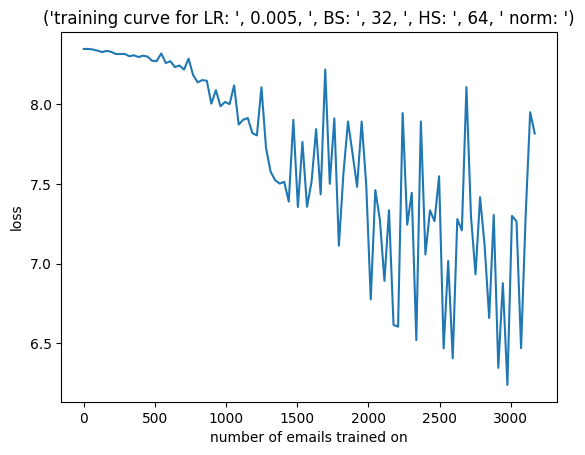

100%|██████████| 100/100 [03:05<00:00,  1.86s/it]


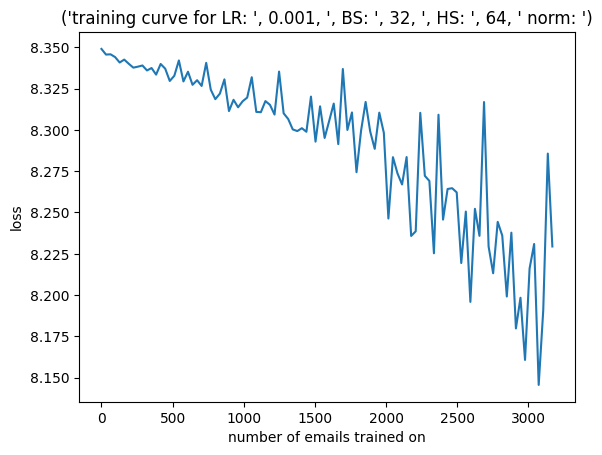

100%|██████████| 100/100 [03:16<00:00,  1.97s/it]


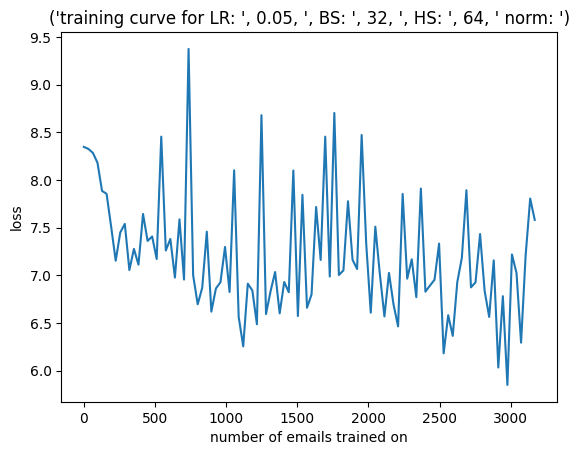

100%|██████████| 100/100 [18:42<00:00, 11.23s/it]


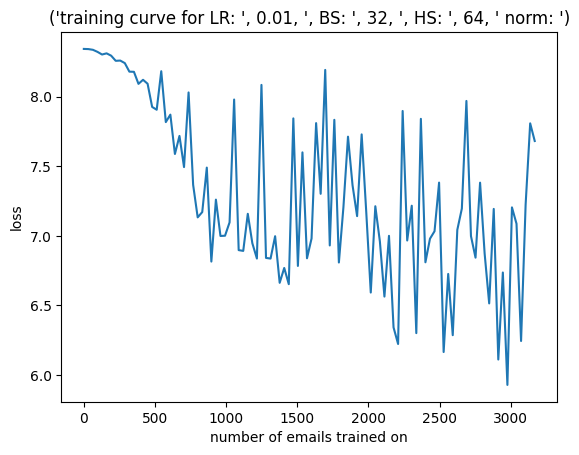

100%|██████████| 100/100 [06:03<00:00,  3.64s/it]


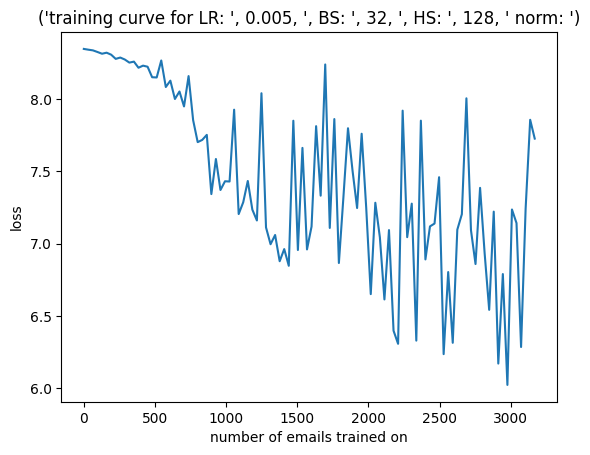

100%|██████████| 100/100 [05:53<00:00,  3.53s/it]


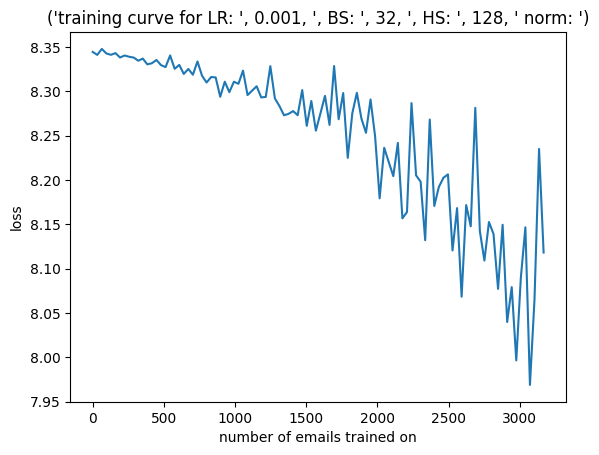

 68%|██████▊   | 68/100 [04:34<02:22,  4.45s/it]

In [574]:
# LOSS CALC Broken
# CHECK TDLDW_Y??
# IDK WHTA else
# MOMENTUM??

grid_search(input_size)

In [162]:

# ex_email = dataset[random.randint(0, 50)]

finalCell, losses = train_LSTM(dataset, input_size, hidden_size, batch_size, 0.001)

plt.plot(np.arange(len(losses)) * batch_size, losses)
plt.title("training curve")
plt.xlabel("number of emails trained on")
plt.ylabel("loss")
plt.show()

NameError: name 'train_LSTM' is not defined